In [111]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import datetime
import os
import json
import matplotlib.dates as mdates
import seaborn as sns
cm = sns.light_palette("green", as_cmap=True)
import psycopg2
from pandas.io.json import json_normalize
from classify_campaigns import classify_campaigns

import dataframe_image as dfi
import matplotlib.ticker as mtick
import matplotlib.dates as mdates

from google.cloud import bigquery
os.environ['GOOGLE_APPLICATION_CREDENTIALS'] = '/Users/daniel.ryu/.config/gcloud/application_default_credentials.json'
bigquery_client = bigquery.Client(project='apprec-prod')

In [112]:
exchange = pd.read_csv('~/Documents/appreciate/exchanges.csv')
imp_type = pd.read_csv('~/Documents/appreciate/imp_type.csv')
buyer = pd.read_csv('~/Documents/appreciate/buyer.csv')

In [113]:
start_dt = '2021-10-19'
end_dt = datetime.date.today()
change_dt = '2021-10-19'
print(start_dt)

2021-10-19


impression/cost/revenue from exclusion list users

In [114]:
def calc_metrics(df, i=0):
    df['ctr'] = 100*df['clicks']/df['impressions']
    df['ir'] = 100*df['installs']/df['clicks']
    df['ipm'] = round(1000*df['installs']/df['impressions'],4)
    df['cpm'] = 1000*df['cost']/df['impressions']
    
    if i != 0:
        df['cost_sov'] = 100*df['cost']/df.groupby(i)['cost'].transform(sum)
        df['total_cost'] = df.groupby(i)['cost'].transform(sum)
        df['revenue_sov'] = 100*df['revenue']/df.groupby(i)['revenue'].transform(sum)
    else:
        df['cost_sov'] = 100*df['cost']/df['cost'].sum()
        df['total_cost'] = df['cost']
        df['revenue_sov'] = 100*df['revenue']/df['revenue'].sum()
        
    df['profit'] = df['revenue']-df['cost']
    df['margin'] = 100*df['profit']/df['revenue']
    return df[['impressions','clicks','ctr','installs','ir','ipm','cpm','revenue','revenue_sov','cost','cost_sov','profit','margin','total_cost']]

format_map = {'impressions':'{:,.0f}'
             ,'bids':'{:,.0f}'
             ,'clicks':'{:,.0f}'
             ,'installs':'{:,.0f}'
             ,'revenue':'${:,.0f}'
             ,'cost':'${:,.0f}'
             ,'profit':'${:,.0f}'
             ,'bpm':'${:,.2f}'
             ,'cpm':'${:,.2f}'
             ,'win_rate':'{:,.1f}%'
             ,'ctr':'{:,.0f}%'
             ,'margin':'{:,.0f}%'
             ,'ir':'{:,.1f}%'
             ,'ipm':'{:,.2f}'
             ,'revenue_sov':'{:,.1f}%'
             ,'uninstall_rate':'{:,.0f}%'
             ,'cost_sov':'{:,.1f}%'
             ,'imp_sov':'{:,.1f}%'
             ,'impressions':'{:,.0f}'
             ,'clicks':'{:,.0f}'
             ,'installs':'{:,.0f}'
             ,'revenue':'${:,.0f}'
             ,'cost':'${:,.0f}'
             ,'cpm':'${:,.2f}'
             ,'ctr':'{:,.1f}%'
             ,'uninstall_rate':'{:,.1f}%'
             ,'ir':'{:,.1f}%'
             ,'ipm':'{:,.2f}'
             ,'revenue_sov':'{:,.1f}%'
             ,'imp_sov_AdColony':'{:,.1f}%'
             ,'impressions_AdColony':'{:,.0f}'
             ,'clicks_AdColony':'{:,.0f}'
             ,'installs_AdColony':'{:,.0f}'
             ,'revenue_AdColony':'${:,.0f}'
             ,'cost_sov_AdColony':'{:,.0f}%'
             ,'margin_AdColony':'{:,.0f}%'
             ,'profit_AdColony':'${:,.0f}'
             ,'cost_AdColony':'${:,.0f}'
             ,'cpm_AdColony':'${:,.2f}'
             ,'ctr_AdColony':'{:,.1f}%'
             ,'ir_AdColony':'{:,.1f}%'
             ,'ipm_AdColony':'{:,.2f}'
             ,'revenue_sov_AdColony':'{:,.1f}%'
             ,'imp_sov_AppLovin':'{:,.1f}%'
             ,'impressions_AppLovin':'{:,.0f}'
             ,'clicks_AppLovin':'{:,.0f}'
             ,'installs_AppLovin':'{:,.0f}'
             ,'revenue_AppLovin':'${:,.0f}'
             ,'cost_sov_AppLovin':'{:,.0f}%'
             ,'margin_AppLovin':'{:,.0f}%'
             ,'profit_AppLovin':'${:,.0f}'
             ,'cost_AppLovin':'${:,.0f}'
             ,'cpm_AppLovin':'${:,.2f}'
             ,'ctr_AppLovin':'{:,.1f}%'
             ,'ir_AppLovin':'{:,.1f}%'
             ,'ipm_AppLovin':'{:,.2f}'
             ,'revenue_sov_AppLovin':'{:,.1f}%'
             ,'imp_sov_Fyber':'{:,.1f}%'
             ,'impressions_Fyber':'{:,.0f}'
             ,'clicks_Fyber':'{:,.0f}'
             ,'installs_Fyber':'{:,.0f}'
             ,'revenue_Fyber':'${:,.0f}'
             ,'cost_sov_Fyber':'{:,.0f}%'
             ,'margin_Fyber':'{:,.0f}%'
             ,'profit_Fyber':'${:,.0f}'
             ,'cost_Fyber':'${:,.0f}'
             ,'cpm_Fyber':'${:,.2f}'
             ,'ctr_Fyber':'{:,.1f}%'
             ,'ir_Fyber':'{:,.1f}%'
             ,'ipm_Fyber':'{:,.2f}'
             ,'revenue_sov_Fyber':'{:,.1f}%'}

In [115]:
df = bigquery_client.query(f"""
select 
    date(r.etimestamp) as date 
    , sp.bundle as sponsored_bnd
    , sp.name as sponsored_app_name
    , ho.bundle as hosting_bnd
    , ho.name as hosting_app_name
    , c.name as campaign_name
    , r.ssb_buyer_id
    , r.ad_size
    , r.ad_type
    , r.imp_type
    , r.creative_id
    , r.ssb_creative_uuid
    , r.exchange_id
    , co.click_x
    , co.click_y
    , if(co.click_x is not null,1,0) has_click_x
    , if(co.click_y is not null,1,0) has_click_y
    , 2*count(case when event_type = 'click' then 1 else NULL end) as clicks
    , 2*count(case when event_type = 'install' then 1 else NULL end) as installs
    , 2*count(ui.timestamp) as uninstalls
    , 2*sum(case when event_type = 'install' then revenue else 0 end) as revenue
from stats.rows1 r
left join 
(
    select id, click_x, click_y
    from 
    (
        select id
        , click_x
        , click_y
        , etimestamp
        , row_number() over (partition by id order by etimestamp desc) rn
        from stats.rows1 r
        where date(etimestamp) >= date('{start_dt}') - 7
        and date(etimestamp) <= '{end_dt}'
        and right(r.tid,1) in ('0','1','2','3','4','5','6','7')
        and event_type = 'click'
    ) t 
    where rn = 1
) co
    on r.id = co.id
join metadata.campaigns c
    on r.ssb_campaign_uuid = c.uuid
join metadata.apps sp
    on r.sponsored_app_id = sp.app_id
join metadata.apps ho
    on r.hosting_app_id = ho.app_id
left join 
(
    select tid, bundle, max(t_created) as timestamp
    from audiences.dt_aud 
    where type = 'uninstall'
    and date(t_created) >= '{start_dt}'
    and date(t_created) <= '{end_dt}' + 1
    and right(tid,1) in ('0','1','2','3','4','5','6','7')
    group by 1,2
) ui 
    on r.tid = ui.tid 
    and r.event_type = 'install'
    and ui.bundle = sp.bundle
    and ui.timestamp - r.timestamp <= interval 1 day 
where 
    date(r.etimestamp) >= '{start_dt}'
    and date(r.etimestamp) <= '{end_dt}'
    and right(r.tid,1) in ('0','1','2','3','4','5','6','7')
group by 1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16
""").to_dataframe()
df = pd.merge(df, imp_type, left_on = 'imp_type', right_on = 'imp_type_id', how = 'left')
df = pd.merge(df, exchange, on = 'exchange_id', how = 'left')

In [116]:
df[['installs','uninstalls']].sum()

installs      2681344
uninstalls     575774
dtype: int64

# Availability

In [117]:
i = ['date']
pivot = df.pivot_table(values = 'clicks', columns = ['has_click_x','has_click_y'], index = i, aggfunc = np.sum, margins = True)
pivot.fillna(0, inplace = True)
pivot.head(30).style.format('{:,.0f}').background_gradient(cmap=cm)

In [118]:
i = ['ssb_buyer_id']
pivot = df.pivot_table(values = 'clicks', columns = ['has_click_x','has_click_y'], index = i, aggfunc = np.sum, margins = True)
pivot.sort_values('All', ascending = False, inplace = True)
pivot.fillna(0, inplace = True)
pivot['coverage'] = 100*pivot[(1,1)]/pivot['All']
pivot.head(30).style.format('{:,.0f}').format({('coverage',''):'{:,.0f}%'}).background_gradient(cmap=cm)

In [119]:
i = ['impression type','ad_size']
pivot = df.pivot_table(values = 'clicks', columns = ['has_click_x','has_click_y'], index = i, aggfunc = np.sum, margins = True)
pivot.sort_values('All', ascending = False, inplace = True)
pivot.fillna(0, inplace = True)
coord_sizes = pivot[(pivot[(1,1)] > 0) & (pivot.index != ('All',''))].index.get_level_values(1).tolist()
pivot['coverage'] = 100*pivot[(1,1)]/pivot['All']
pivot.head(30).style.format('{:,.0f}').format({('coverage',''):'{:,.0f}%'}).background_gradient(cmap=cm)

In [120]:
i = ['exchange_name']
filters =(df.date == pd.to_datetime(end_dt)) & (df['impression type'] == 'display') & (df['ad_size'].isin(['320x50','320x480','480x320','300x50','728x90']))

pivot = df[filters].pivot_table(values = 'clicks', columns = ['has_click_x','has_click_y'], index = i, aggfunc = np.sum, margins = True)
pivot['coverage'] = 100*pivot[(1,1)]/pivot['All']
pivot.sort_values('All', ascending = False, inplace = True)
pivot.fillna(0, inplace = True)
coord_exchanges = pivot[(pivot[(1,1)] > 0) & (pivot.index != 'All')].index.tolist()

print(f'filter size_types with coordinates - {coord_sizes}')
pivot.head(30).style.format('{:,.0f}').format({('coverage',''):'{:,.1f}%'}).background_gradient(cmap=cm)

filter size_types with coordinates - ['320x50', '320x480', '480x320', '300x50', '728x90', '768x1024', '1024x768', '160x600', '320x100', '640x100']


In [121]:
i = ['exchange_name','date']
filters = (df.exchange_name.isin(coord_exchanges)) & (df['impression type'] == 'display') & (df['ad_size'].isin(['320x50','320x480','480x320','300x50','728x90']))

pivot = df[filters].pivot_table(values = 'clicks', columns = ['has_click_x','has_click_y'], index = i, aggfunc = np.sum, margins = True)
pivot['coverage'] = 100*pivot[(1,1)]/pivot['All']
pivot.fillna(0, inplace = True)

print(f'filter size_types with coordinates - {coord_sizes}')
pivot.style.format('{:,.0f}').format({('coverage',''):'{:,.1f}%'}).background_gradient(cmap=cm)

filter size_types with coordinates - ['320x50', '320x480', '480x320', '300x50', '728x90', '768x1024', '1024x768', '160x600', '320x100', '640x100']


In [122]:
filters = (df.ad_size.isin(coord_sizes)) & (df.exchange_name == 'AppLovin') & (df['impression type'] == 'display')
pivot = df[filters].pivot_table(values = 'clicks', index = ['creative_id','ad_size'], columns = ['has_click_x','has_click_y'], aggfunc = np.sum, margins = True)
pivot = pivot.fillna(0)
pivot['coverage'] = 100*pivot[(1,1)]/pivot['All']
pivot.sort_values([('All','')], ascending = False, inplace = True)
pivot.to_csv(f'~/Downloads/coordinate_coverage_by_creative_id_{start_dt}_{end_dt}.csv')
pivot.head(40).style.format('{:,.0f}').format({('coverage',''):'{:,.0f}%'}).background_gradient(cmap = cm)

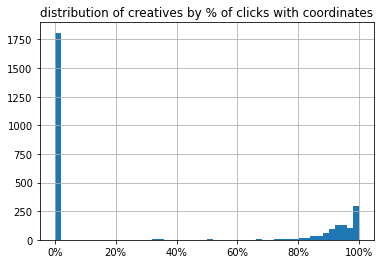

In [123]:
pivot[('coverage','')].hist(bins = 50)
plt.title('distribution of creatives by % of clicks with coordinates')
plt.gca().xaxis.set_major_formatter(mtick.PercentFormatter(100))

Either a creative has almost all clicks with coordinates, or none. There must be some factor different for certain creatives..

Add to ticket. 

In [124]:
filters = (df.ad_size.isin(coord_sizes)) & (df.exchange_name.isin(coord_exchanges)) & (df['impression type'] == 'display') & (df.creative_id == '3549_896673b8c662aa49fadecf18c09011c2')
pivot = df[filters].pivot_table(values = 'clicks', index = ['date'], columns = ['has_click_x','has_click_y'], aggfunc = np.sum, margins = True)
pivot = pivot.fillna(0)
pivot['coverage'] = 100*pivot[(1,1)]/pivot['All']
pivot.head(40).style.format('{:,.0f}').format({('coverage',''):'{:,.0f}%'}).background_gradient(cmap = cm)

In [125]:
# split of known rev
filters = (df.ad_size.isin(coord_sizes)) & (df.exchange_name.isin(coord_exchanges))
pivot = df.pivot_table(values = 'clicks', index = 'date', columns = ['has_click_x','has_click_y'], aggfunc = np.sum, margins = True)
pivot['coverage'] = 100*pivot[(1,1)]/pivot['All']
pivot.style.format('{:,.0f}').format({('coverage',''):'{:,.1f}%'})

# Heatmap

Text(0.5, 1.0, 'click heatmap')

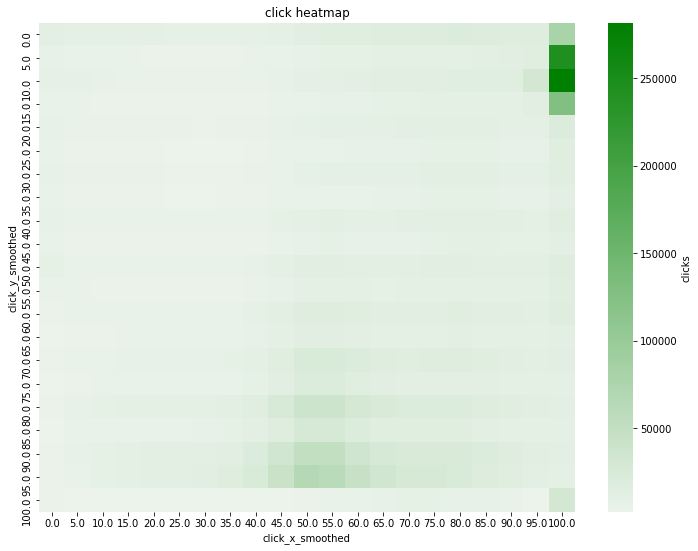

In [126]:
# aggregates clicks (1-100)
smoothing = 5

df['click_x_smoothed'] = smoothing*np.floor(df['click_x']/smoothing)
df['click_y_smoothed'] = smoothing*np.floor(df['click_y']/smoothing)
filters = (df.ad_size.isin(coord_sizes)) & (df.exchange_name.isin(coord_exchanges)) & (df['impression type'] == 'display')
clicks_by_coord = df[filters].pivot_table(values = 'clicks', index = 'click_y_smoothed', columns = 'click_x_smoothed', aggfunc = np.sum)

fig, ax = plt.subplots(figsize = (12,9))
ax.xaxis.set_major_formatter(mtick.StrMethodFormatter('{x:,.3f}'))
g = sns.heatmap(clicks_by_coord, ax = ax, figure = fig, cmap = cm, cbar_kws = {'label':'clicks'})
ax.set_title('click heatmap')



Text(0.5, 1.0, 'heatmap of revenue coming from click coordinates')

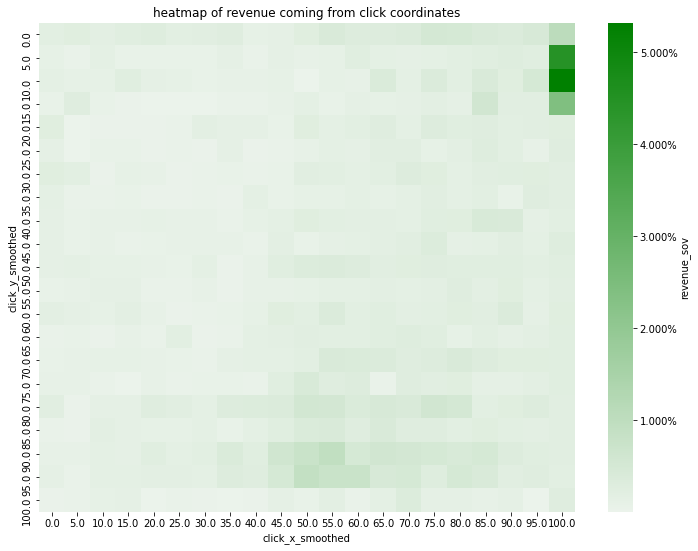

In [127]:
# aggregates clicks (1-100)
smoothing = 5

df['click_x_smoothed'] = smoothing*np.floor(df['click_x']/smoothing)
df['click_y_smoothed'] = smoothing*np.floor(df['click_y']/smoothing)
filters = (df.ad_size.isin(coord_sizes)) & (df.exchange_name.isin(coord_exchanges)) & (df['impression type'] == 'display')
rev_by_coord = df[filters].pivot_table(values = 'revenue', index = 'click_y_smoothed', columns = 'click_x_smoothed', aggfunc = np.sum)
rev_total = df.loc[filters & (~df.click_x_smoothed.isna()) & (~df.click_y_smoothed.isna()),'revenue'].sum()
rev_sov_by_coord = 100*rev_by_coord.div(rev_total)

fig, ax = plt.subplots(figsize = (12,9))
ax.xaxis.set_major_formatter(mtick.StrMethodFormatter('{x:,.3f}'))
g = sns.heatmap(rev_sov_by_coord, ax = ax, figure = fig, cmap = cm, cbar_kws = {'label':'revenue_sov','format':'%.3f%%'})
ax.set_title('heatmap of revenue coming from click coordinates')



Text(0.5, 1.0, 'heatmap of uninstalls coming from click coordinates')

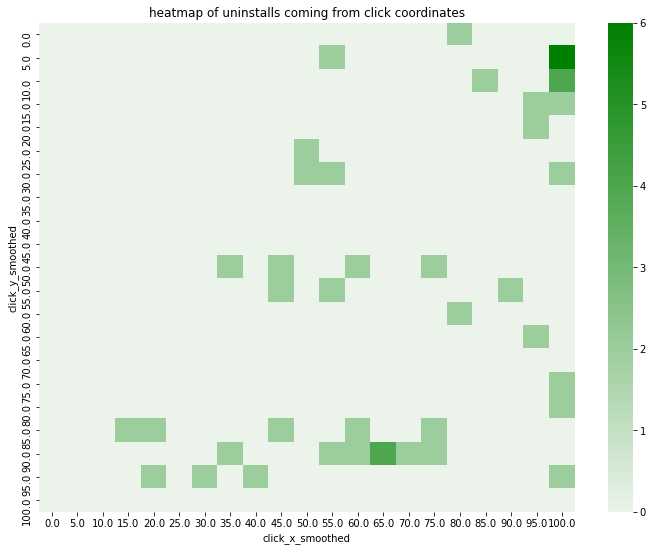

In [128]:
# aggregates clicks (1-100)
smoothing = 5

df['click_x_smoothed'] = smoothing*np.floor(df['click_x']/smoothing)
df['click_y_smoothed'] = smoothing*np.floor(df['click_y']/smoothing)
filters = (df.ad_size.isin(coord_sizes)) & (df.exchange_name.isin(coord_exchanges)) & (df['impression type'] == 'display')
uninstalls_by_coord = df[filters].pivot_table(values = 'uninstalls', index = 'click_y_smoothed', columns = 'click_x_smoothed', aggfunc = np.sum)
uninstalls_by_coord.style.background_gradient(cmap=cm)


fig, ax = plt.subplots(figsize = (12,9))
ax.xaxis.set_major_formatter(mtick.StrMethodFormatter('{x:,.3f}'))
g = sns.heatmap(uninstalls_by_coord, ax = ax, figure = fig, cmap = cm)
ax.set_title('heatmap of uninstalls coming from click coordinates')



Text(0.5, 1.0, 'heatmap of revenue coming from click coordinates (AppLovin interstitials only)')

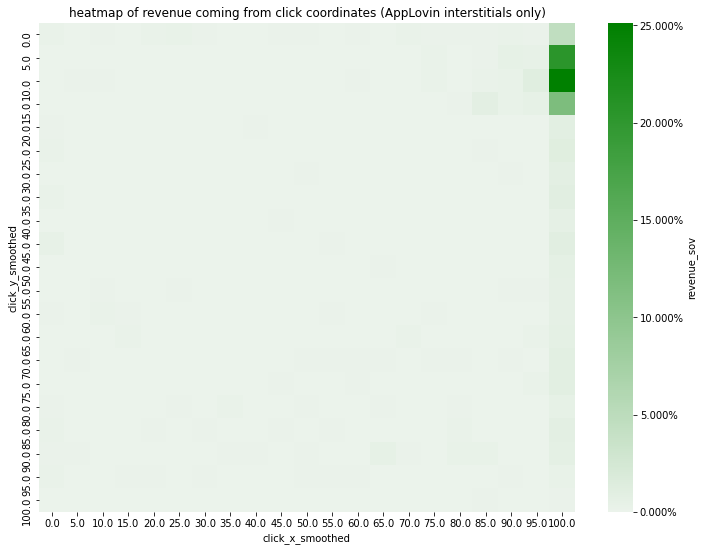

In [129]:
# aggregates clicks (1-100)
smoothing = 5

df['click_x_smoothed'] = smoothing*np.floor(df['click_x']/smoothing)
df['click_y_smoothed'] = smoothing*np.floor(df['click_y']/smoothing)
filters = (df.ad_size.isin(coord_sizes)) & (df.exchange_name == 'AppLovin')& (df.ad_type == 'inter') & (df['impression type'] == 'display')
rev_by_coord = df[filters].pivot_table(values = 'revenue', index = 'click_y_smoothed', columns = 'click_x_smoothed', aggfunc = np.sum)
rev_total = df.loc[filters & (~df.click_x_smoothed.isna()) & (~df.click_y_smoothed.isna()),'revenue'].sum()
rev_sov_by_coord = 100*rev_by_coord.fillna(0).div(rev_total)

fig, ax = plt.subplots(figsize = (12,9))
ax.xaxis.set_major_formatter(mtick.StrMethodFormatter('{x:,.3f}'))
g = sns.heatmap(rev_sov_by_coord, ax = ax, figure = fig, cmap = cm, cbar_kws = {'label':'revenue_sov','format':'%.3f%%'})
ax.set_title('heatmap of revenue coming from click coordinates (AppLovin interstitials only)')



# rev by region

In [130]:
def classify_region(x):
    corner_size = 15
    if (x.click_x > 100-corner_size or x.click_x < corner_size) and (x.click_y > 100-corner_size or x.click_y < corner_size):
        return 'corner'
    elif (x.click_x > 100-corner_size or x.click_x < corner_size) or (x.click_y > 100-corner_size or x.click_y < corner_size):
        return 'border'
    elif pd.isna(x.click_x) or pd.isna(x.click_y):
        return 'no coord'
    else:
        return 'middle'

df['click_region'] = df.apply(lambda x:classify_region(x), axis = 1)


In [131]:
filters = (df.ad_size.isin(coord_sizes)) & (df.exchange_name.isin(coord_exchanges)) & (df['impression type'] == 'display')
pivot = df[filters].pivot_table(values = ['clicks','installs','uninstalls','revenue'], index = 'click_region', aggfunc = np.sum, margins = True)
sov_pivot = 100*pivot.div(pivot.iloc[-1]).iloc[:-1]
sov_pivot.style.format('{:,.1f}%')

In [132]:
filters = (df.ad_size.isin(coord_sizes)) & (df.exchange_name.isin(coord_exchanges)) & (df.ad_type == 'inter')  & (df['impression type'] == 'display')
pivot = df[filters].pivot_table(values = ['clicks','installs','uninstalls','revenue'], index = 'click_region', aggfunc = np.sum, margins = True)
sov_pivot = 100*pivot.div(pivot.iloc[-1]).iloc[:-1]
print('Interstitials only')
sov_pivot.style.format('{:,.1f}%')

Interstitials only


In [133]:
filters = (df.ad_size.isin(coord_sizes)) & (df.exchange_name == 'AppLovin') & (df.ad_type == 'inter') & (df['impression type'] == 'display')
pivot = df[filters].pivot_table(values = ['clicks','installs','uninstalls','revenue'], index = 'click_region', aggfunc = np.sum, margins = True)
sov_pivot = 100*pivot.div(pivot.iloc[-1]).iloc[:-1]
print('AppLovin Interstitials only')
sov_pivot.style.format('{:,.1f}%')

AppLovin Interstitials only


In [134]:
filters = (df.ad_size.isin(coord_sizes)) & (df.exchange_name.isin(coord_exchanges))  & (df['impression type'] == 'display')
pivot = df[filters].pivot_table(values = 'clicks', index = 'click_region', columns = 'ad_type', aggfunc = np.sum, margins = True)
sov_pivot = 100*pivot.div(pivot.iloc[-1]).iloc[:-1]
print('distribution of clicks by type')
sov_pivot.style.format('{:,.1f}%')

distribution of clicks by type


In [135]:
filters = (df.ad_size.isin(coord_sizes)) & (df.exchange_name.isin(coord_exchanges))  & (df['impression type'] == 'display')
pivot = df[filters].pivot_table(values = 'revenue', index = 'click_region', columns = 'ad_type', aggfunc = np.sum, margins = True)
sov_pivot = 100*pivot.div(pivot.iloc[-1]).iloc[:-1]
print('distribution of revenue by type')
sov_pivot.style.format('{:,.1f}%')

distribution of revenue by type


In [136]:
df['hosting_bnd'].isna().sum()

0

In [137]:
i = 'hosting_bnd'
filters = (df.ad_size.isin(coord_sizes)) & (df.exchange_name.isin(coord_exchanges)) & (df['impression type'] == 'display')
pivot = df[filters].pivot_table(values = 'installs', index = i, columns = 'click_region', aggfunc = np.sum, margins = True)
pivot['corner_install_pct'] = 100*pivot['corner']/pivot['All']
pivot.sort_values('All', ascending = False, inplace = True)
pivot.head(40).style.format('{:,.0f}').format({'corner_install_pct':'{:,.1f}%'}).background_gradient(cmap=cm,subset = 'corner_install_pct')